### 1
•	Загрузите дневные котировки 3 акций (Apple, Google, Facebook) из открытых источников за последние 10 лет:

In [3]:
from time import sleep
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.stats import chisquare
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from scipy.stats import kstest
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from itertools import combinations
import xgboost as xgb
# %matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\Dell\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
api_key = '3YMNSYCH79H1MNH7'
data={}
for s in ['AAPL','GOOG','META']:
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={s}&outputsize=full&apikey={api_key}'
    r = requests.get(url)
    data_dict = r.json()
    df = pd.DataFrame.from_dict(data_dict['Time Series (Daily)'],orient='index')
    df = pd.DataFrame(df['5. adjusted close'].astype(float))
    df.columns = ['close']
    data[s] = df
    sleep(1)

print(data.keys())

dict_keys(['AAPL', 'GOOG', 'META'])


In [5]:
data['AAPL'].head()

,close
2022-12-02,147.81
2022-12-01,148.31
2022-11-30,148.03
2022-11-29,141.17
2022-11-28,144.22


### 2
•	Посчитайте daily returns r_i   =((P_(i+1)  - P_i  ))/P_i   , где i -день, и i + 1 –след. день

In [6]:
lens=[]
for s in ['AAPL','GOOG','META']:
    data[s]['lag1'] = data[s].close.shift(-1)
    data[s]['d_r'] = (data[s].lag1 - data[s].close)/data[s].close
    data[s] = data[s].dropna()
    len_=len(data[s])
    lens.append(len_)
    print(f'len of {s}:', len_)
min_len = min(lens) 

len of AAPL: 5810
len of GOOG: 2188
len of META: 2653


In [7]:
data['AAPL'].head()

,close,lag1,d_r
2022-12-02,147.81,148.31,0.003383
2022-12-01,148.31,148.03,-0.001888
2022-11-30,148.03,141.17,-0.046342
2022-11-29,141.17,144.22,0.021605
2022-11-28,144.22,148.11,0.026973


#### Нормируем daily returns и построим плотности распределений в сравнении с gaussian distribution

AAPL median() : -0.010768386752673843
 Kolmogorov-Smirnov Test: statistic=0.0991, p-value=0.0000
GOOG median() : -0.023543501488718848
 Kolmogorov-Smirnov Test: statistic=0.0690, p-value=0.0001
META median() : -0.0293583913409073
 Kolmogorov-Smirnov Test: statistic=0.0935, p-value=0.0000


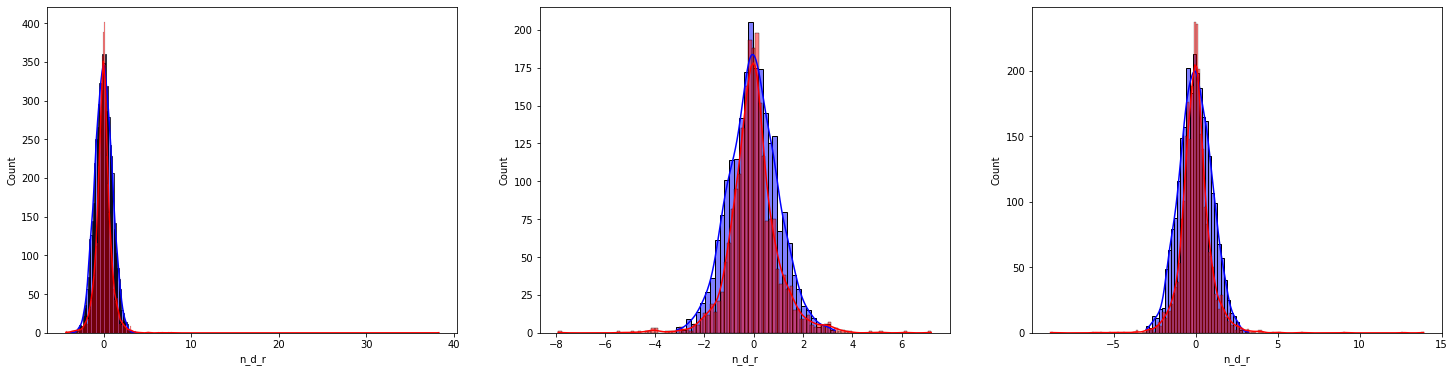

In [8]:
np.random.seed(0)


fig, axes = plt.subplots(1, 3, figsize=(25, 6))
for s, i in zip(['AAPL','GOOG','META'], range(len(['AAPL','GOOG','META']))):
    rand_gauss_value = np.random.normal(size=len(data[s]))
    data[s]['n_d_r'] = StandardScaler().fit_transform(data[s].d_r.values.reshape(-1,1)).squeeze()
    sns.histplot(rand_gauss_value, kde=True, ax=axes.flat[i], color = 'blue')
    sns.histplot(data[s].n_d_r, kde=True, ax=axes.flat[i], color = 'red')
   
    print(s + ' median() :', data[s]['n_d_r'].median())    
    stat, p_value = kstest(data[s]['n_d_r'], rand_gauss_value)
    print(f" Kolmogorov-Smirnov Test: statistic={stat:.4f}, p-value={p_value:.4f}")

#### Выводы
1. У всех трех акций можно отметить небольшое значение positive skewness (mean>median), что указывает на бОльшую частоту крупных просадок цен, чем это должно было быть при нормальном распределении.
2. У всех трех акций имеется kurtois, или "тяжелые хвосты", опять же свидетельствующие о более частых (чем "положено") аномальных движениях. 
3. В тесте Колмогорова-Смирнова у всех трех акций p-value <<<1% поэтому с высокой достоверностью отвергаем нулевую гипотезу об одинаковости двух распределений.

Вообще подбор вида распределений цен на фондовом рынке - тема поднимаемая в эконометрической литературе уже много десятилетий. 
Суть одна - строить модели на гипотезе о нормально распределенных доходностях надо как минимум с осторожностью...

#### Посмотрим визульно на ряды и проведем тест adfuller на стационарность

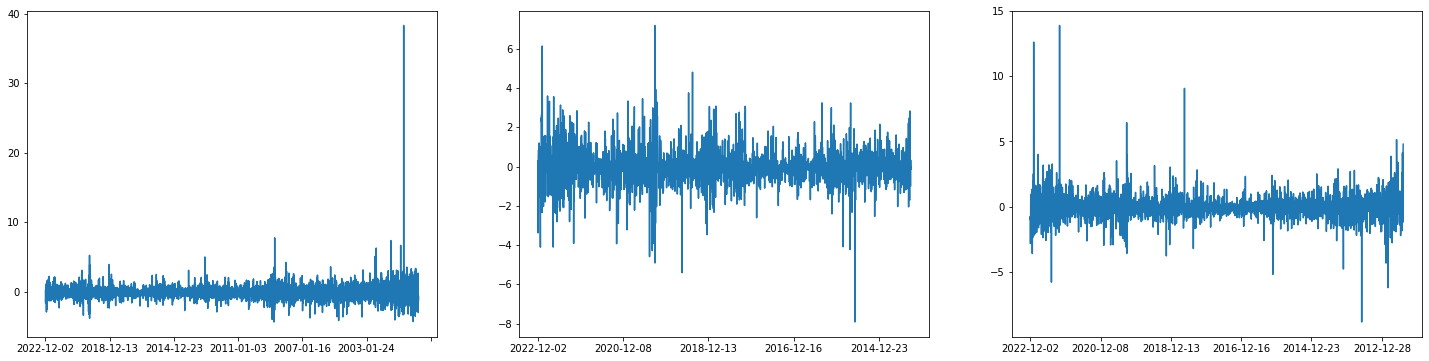

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))
for s, i in zip(['AAPL','GOOG','META'], range(len(['AAPL','GOOG','META']))):
    data[s]['n_d_r'].plot(ax=axes.flat[i])

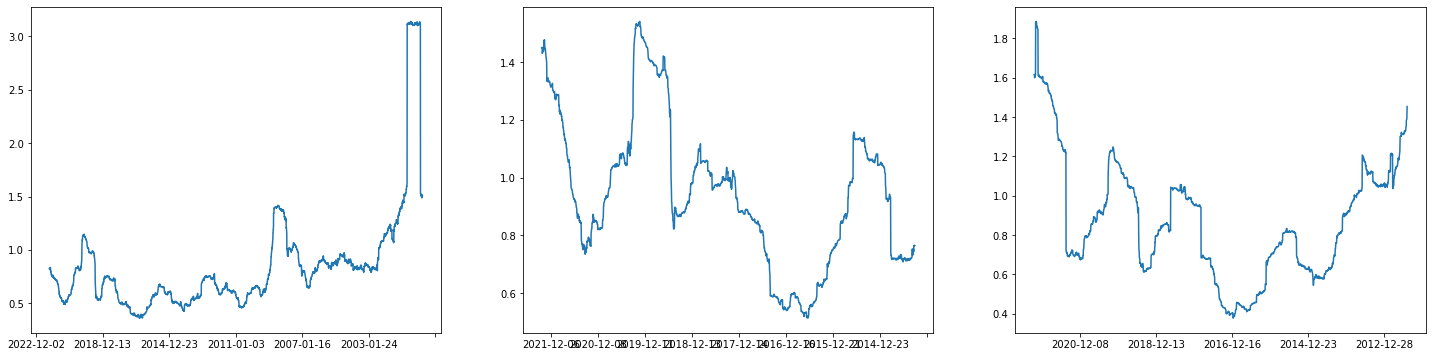

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))
for s, i in zip(['AAPL','GOOG','META'], range(len(['AAPL','GOOG','META']))):
    data[s]['n_d_r'].rolling(200).std().plot(ax=axes.flat[i])

#### Визуально не видно сезонных или трендовых явлений. Однако можно отметить колебания скользящей волатильности, что свидетельствует скорее о нетационарности этих рядов. Есть также несколько аномальных значений. Хотя тестирование скорее всего покажет стационарность.

In [11]:
for s in ['AAPL','GOOG','META']:
    test = adfuller(data[s]['d_r'])
    print('adf: ', test[0])
    print('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0] > test[4]['1%']:  # проверка, больше ли критического полученное значение для нашего ряда
        print(f'Ряд дневных доходностей {s} НЕ стационарен')
    else:
        print(f'Ряд дневных доходностей {s} cтационарен')
    print('-----------------------------------------------')    

adf:  -15.751665582643888
p-value:  1.221235601396624e-28
Critical values:  {'1%': -3.4314806953877275, '5%': -2.8620396600349722, '10%': -2.5670359670726235}
Ряд дневных доходностей AAPL cтационарен
-----------------------------------------------
adf:  -10.47231095265926
p-value:  1.2749377052886702e-18
Critical values:  {'1%': -3.4333670748168506, '5%': -2.8628728385507474, '10%': -2.567479536622141}
Ряд дневных доходностей GOOG cтационарен
-----------------------------------------------
adf:  -15.472861219552161
p-value:  2.616088026310614e-28
Critical values:  {'1%': -3.432827541597229, '5%': -2.862634590579131, '10%': -2.5673526885729334}
Ряд дневных доходностей META cтационарен
-----------------------------------------------


#### Ряды доходностей можно считать стационарными в соответствии с тестом adfuller. Однако учитывая колебания оценочной дисперсии - распределения доходностей этих акции нельзя считать стационарными на всем рассматриваемом интервале.

•	Есть ли взаимосвязь между прошлыми и будущими значениями временного ряда для отдельно выбранной акции? Если да, то значима ли она (для 1 акции)?

#### Посмотрим на самое простое - наличие линейной взаимосвязи с прошлыми значениями с помощью функций автокорреляции и частичной автокорреляции

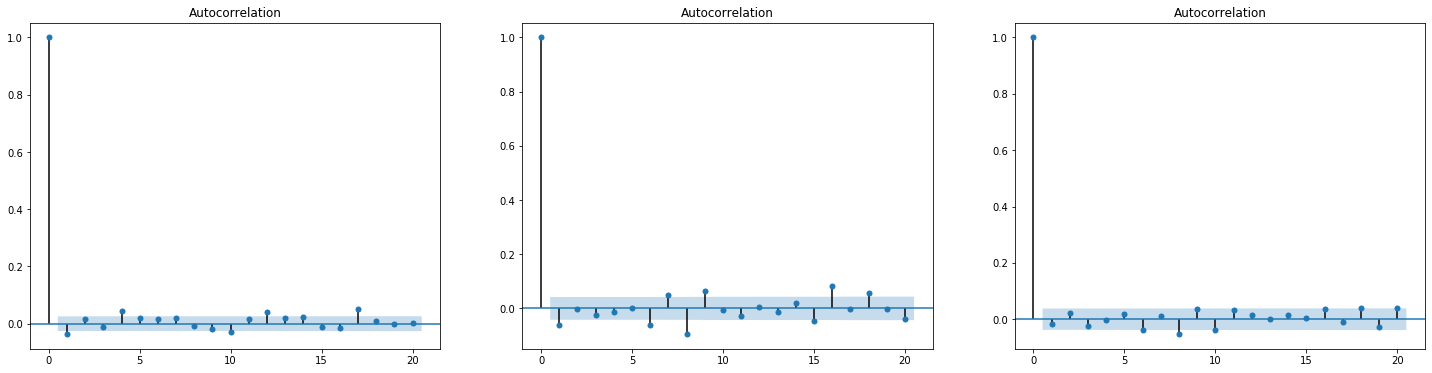

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))
for s, i in zip(['AAPL','GOOG','META'], range(len(['AAPL','GOOG','META']))):
    plot_acf(data[s]['d_r'].values,lags=20,ax=axes.flat[i])

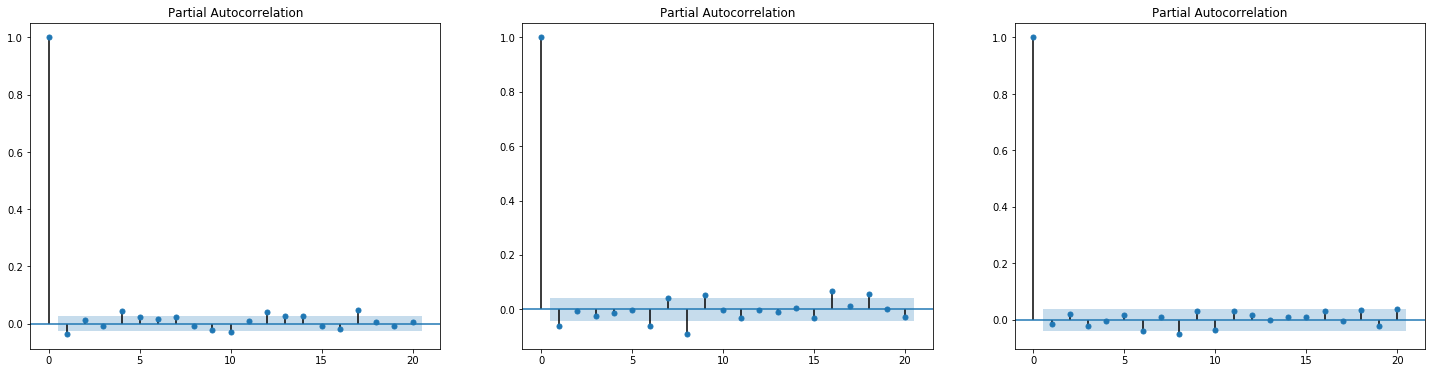

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))
for s, i in zip(['AAPL','GOOG','META'], range(len(['AAPL','GOOG','META']))):
    plot_pacf(data[s]['d_r'].values,lags=20,ax=axes.flat[i])

#### Выводы
Графики АКФ и частичной АКФ свидетельствуют об очень слабых взаимосвязях между прошлыми и будущими значениями рядов. У Apple  и Google можно отметить слабую отрицательную корреляцию с предыдущим значением доходности. Также можно отметить еще несколько лагов, где значение функций АКФ выходит за пределы доверительных интервалов (закрашенная область), что могло бы формально свидетельствовать о значимости этих значений, однако эти значения относительно небольшие. И в целом, применение этих функций требует предварительной стационарности рядов, что, как правило, не соблюдается на фондовом рынке.

•	Есть ли интересные взаимосвязи между return-ами  различных инструментов в один и тот же период по времени? (Предположение: поиск корреляции, Granger causality, PCA decomposition of returns)

#### Построим попарные корреляции рядов

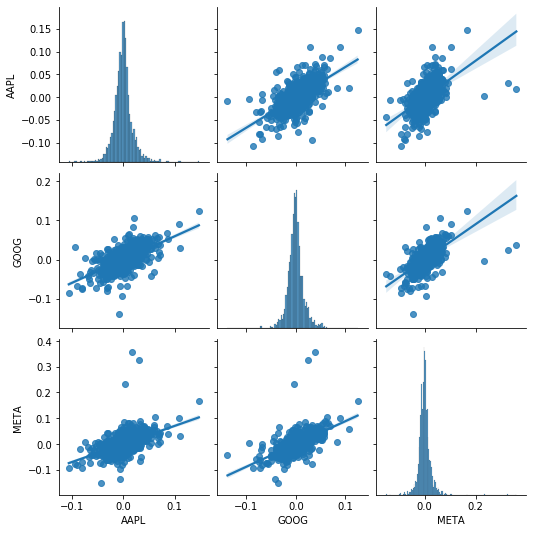

In [14]:
tmp_df = pd.DataFrame()
for s in ['AAPL','GOOG','META']:
    tmp_df[s] = data[s]['d_r'][:min_len]
sns.pairplot(tmp_df,kind='reg')  


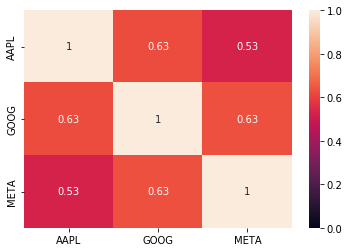

In [15]:
sns.heatmap(tmp_df.corr().abs(), annot=True, vmin=0, vmax=1)

#### Построим функции ВКФ

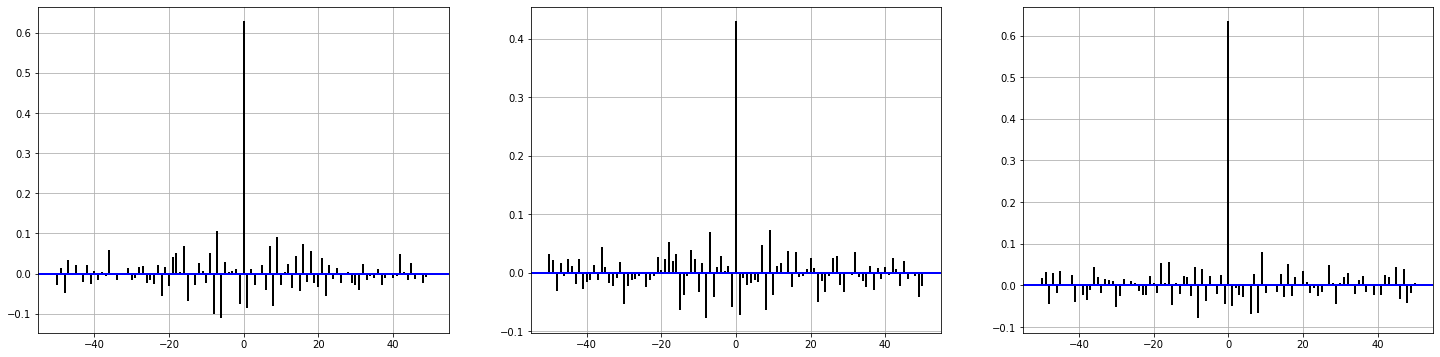

In [16]:
combs = combinations(['AAPL','GOOG','META'], 2)
fig, axes = plt.subplots(1, 3, figsize=(25, 6))
for i,k in enumerate(list(combs)):


    x = data[k[0]]['d_r'].values
    y = data[k[1]]['d_r'].values

    len_=min(len(x),len(y))
    x=x[:len_]
    y=y[:len_]

    # Plot graph
#     fig = plt.figure()
    ax1 = axes.flat[i] #fig.add_subplot(211)

    # cross correlation using
    # xcorr() function
    ax1.xcorr(x, y, usevlines=True,
              maxlags=50, normed=True,
              lw=2)
    # adding grid to the graph
    ax1.grid(True)
    ax1.axhline(0, color='blue', lw=2)
#     ax1.set_title = 'sdf'
    # show final plotted graph
plt.show()

In [17]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag = 12
test   = 'ssr_chi2test'

In [18]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [19]:
combs = combinations(['AAPL','GOOG','META'], 2)
  
for i,k in enumerate(list(combs)):
    tmp_df = pd.DataFrame()
    x = data[k[0]]['d_r'].values
    y = data[k[1]]['d_r'].values

    len_=min(len(x),len(y))
    x=x[:len_]
    y=y[:len_]
    
    tmp_df[k[0]] = x
    tmp_df[k[1]] = y
    
    tmp_df.columns= k
    
    display(grangers_causation_matrix(tmp_df, variables = tmp_df.columns))

,AAPL_x,GOOG_x
AAPL_y,1.0,0.0227
GOOG_y,0.0,1.0000


,AAPL_x,META_x
AAPL_y,1.0,0.0082
META_y,0.0,1.0000


,GOOG_x,META_x
GOOG_y,1.0000,0.3182
META_y,0.0938,1.0000


#### В целом можно отметь очевидную взаимосвязь между текущими доходностями акций. Влияние прошлых значений на будущие несущественно.

### 3
Предположим, каждый день вы получаете предсказание   f_i величины r_i
Введем понятие Profit-and-loss (pnl) для каждого дня
pnl_i  = f_i   * r_i
Пусть f_i имеет распределение standard Gaussian с mean = 0 и std = 1. 
Задача: Сгенерируйте несколько случайных реализаций f_i, постройте графики pnl_i  и pnl = cumsum(pnl_i)


#### Выполним задание, например, для Apple.

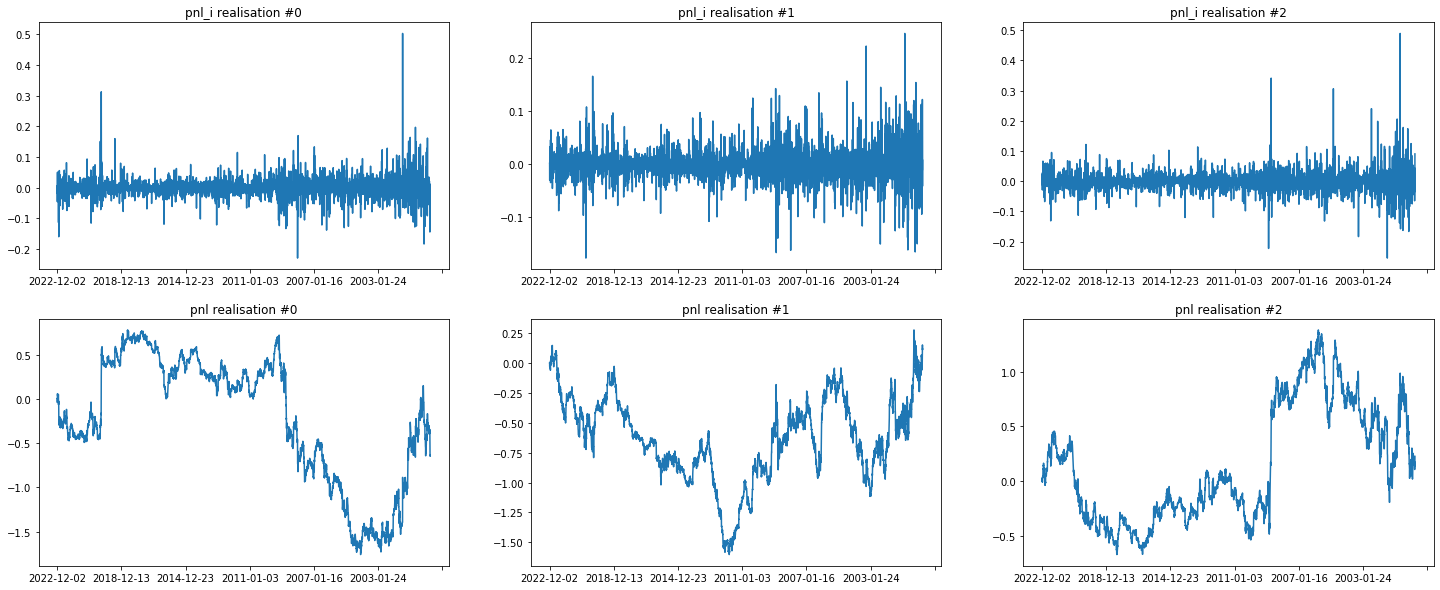

In [20]:
s = 'AAPL'
fig, axes = plt.subplots(2, 3, figsize=(25, 10))
rand_seeds = [0,42,43]
for i,r in enumerate(rand_seeds):
    np.random.seed(r)
    f = np.random.normal(size=len(data[s]))
    data[s]['pnl_i'] = f*data[s]['d_r']
    data[s]['pnl'] = data[s]['pnl_i'].cumsum()
    data[s]['pnl_i'].plot(ax=axes.flat[i], title = f'pnl_i realisation #{i}')
    data[s]['pnl'].plot(ax=axes.flat[i+len(rand_seeds)],title = f'pnl realisation #{i}')

### 4
Для временного ряда (например, доходностей) коэффициент Sharpe Ratio определяется как SR = E [pnl_i ]/√(V[pnl_i ] )
Представьте, что каждый день вы делаете случайное предсказание f_i  согласно стандартному распределению для конкретной акции. Качество ваших предсказаний можно охарактеризовать с помощью
 hit rate =1/n  *(∑_i▒〖 I(sign(f_i) == sign(r_i)))〗  
Hit rate - это мера точности: то, как часто наш прогноз совпадает по направлению движения акции .
f_i  это случайная величина, имеющая множество реализаций 
Постройте scatter plot SR(pnl_i) от hit rate в диапазоне от 0 до 1


<function matplotlib.pyplot.show(*args, **kw)>

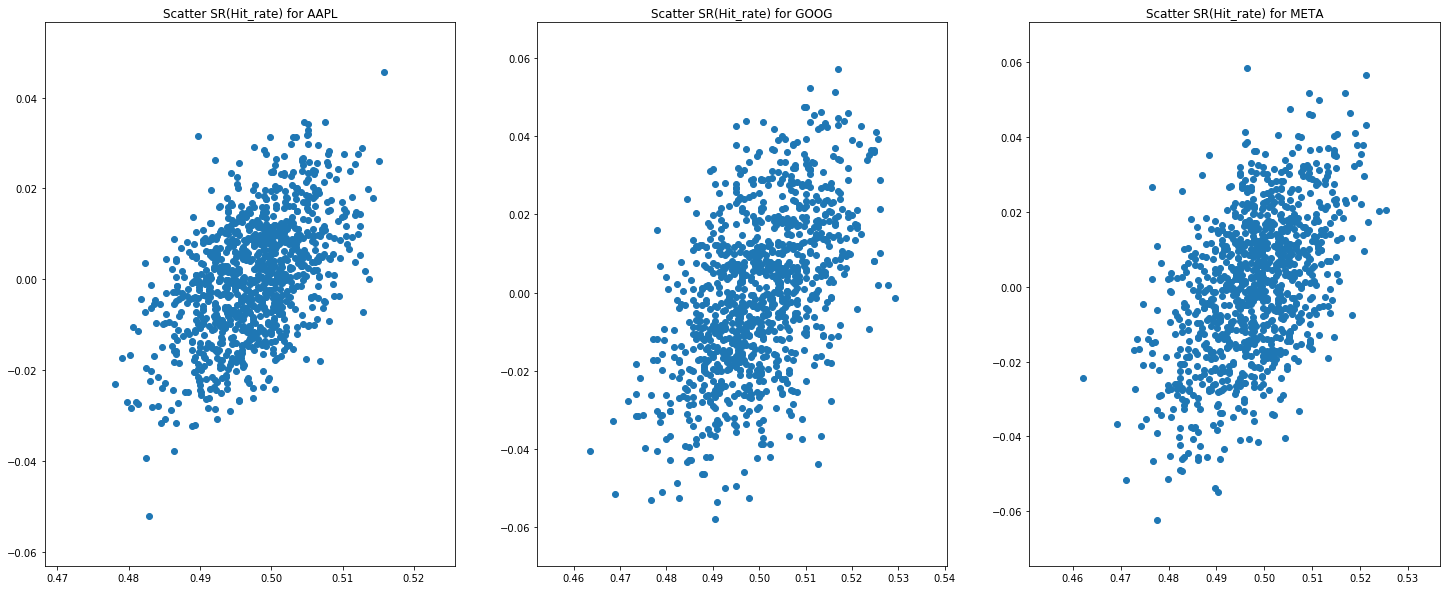

In [31]:
#Sharpe_Ratio = portf_val[‘Daily Return’].mean() / portf_val[‘Daily Return’].std()
fig, axes = plt.subplots(1, 3, figsize=(25, 10))
np.random.seed(42)

stats = {}
for i,s in enumerate(['AAPL','GOOG','META']):
    stats[s] = {}
    stats[s]['SR'] = []
    stats[s]['Hit_rate'] = []
for i,s in enumerate(['AAPL','GOOG','META']):    
    for k in range(1000):
        f = np.random.normal(size=len(data[s]))

        data[s]['pnl_i'] = f*data[s]['d_r']
        data[s]['pnl'] = data[s]['pnl_i'].cumsum()

        SR_k = data[s]['pnl_i'].mean()/data[s]['pnl_i'].std()
    #     print(SR_k)
        stats[s]['SR'].append(SR_k)
        HR_k = np.mean(np.sign(f)==np.sign(data[s]['d_r']))
    #     print(HR_k)
        stats[s]['Hit_rate'].append(HR_k)
#   plt.title()
    
    ax1 = axes.flat[i]
    ax1.set_title(f"Scatter SR(Hit_rate) for {s}")
    ax1.scatter(stats[s]['Hit_rate'], stats[s]['SR'] )
    
plt.show

#### 5
Постройте модель классификации на представленных данных и заполните пустые значения.

In [22]:
df = pd.read_csv('xtask.csv')

In [23]:
df

,a,b,c,d,class
0,-0.233408,-0.845698,0.365256,0.311292,1.0
1,0.073524,-0.747284,0.586381,0.303840,1.0
2,0.105561,-0.749805,0.149815,0.635771,1.0
3,-0.642419,-0.342424,-0.608454,0.229135,0.0
4,0.296581,-0.656553,0.022429,0.639708,0.0
...,...,...,...,...,...
3834,-0.926398,0.171996,-0.333049,0.035802,NaN
3835,0.787500,-0.355948,0.425932,-0.200971,NaN
3836,0.282760,-0.569896,-0.231674,0.735929,NaN
3837,-0.599582,-0.749842,0.265262,-0.088739,NaN


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3839 entries, 0 to 3838
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a       3839 non-null   float64
 1   b       3839 non-null   float64
 2   c       3839 non-null   float64
 3   d       3839 non-null   float64
 4   class   3071 non-null   float64
dtypes: float64(5)
memory usage: 150.1 KB


In [25]:
df.describe()

,a,b,c,d,class
count,3839.000000,3839.000000,3839.000000,3839.000000,3071.00000
mean,0.000237,-0.001918,-0.005020,0.017286,0.65972
std,0.492286,0.493000,0.489641,0.504631,0.47388
min,-0.995371,-0.996342,-0.996055,-0.998084,0.00000
25%,-0.394078,-0.395845,-0.395307,-0.386948,0.00000
50%,-0.008509,-0.010900,-0.015388,0.015544,1.00000
75%,0.399061,0.395606,0.382006,0.436341,1.00000
max,0.995987,0.993865,0.988428,0.997183,1.00000


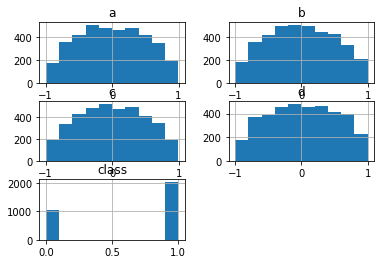

In [26]:
for i in [df.columns]:
    df[i].hist()

#### Все признаки находятся в диапазоне (0,1) и видимо отнормированы.

In [27]:
# df_ = df[df['class'].notna()]
df_=df

In [28]:
import h2o
from sklearn.preprocessing import LabelEncoder 
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,24 mins 26 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,4 months and 25 days !!!
H2O_cluster_name:,H2O_from_python_Dell_w99qvj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.705 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [29]:
df_ = h2o.H2OFrame(df_)
df_['class'] = df_['class'].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [30]:
# Разделяем данные на Train/Test/Validation. Train размером 70%, test и validation по 15% 
train_df, test_df = df_.split_frame(ratios=[.7])

In [32]:
y = "class"
train_columns = train_df.columns
train_columns.remove(y)

aml_model = H2OAutoML(max_runtime_secs=500, seed = 1)
aml_model.train(x = train_columns, y = y, training_frame = train_df)

AutoML progress: |
23:21:14.981: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_5_AutoML_2_20221203_232114

No model summary for this model

ModelMetricsBinomial: stackedensemble
** Reported on train data. **

MSE: 0.2088454190436208
RMSE: 0.4569960820878236
LogLoss: 0.6052539687534891
Mean Per-Class Error: 0.42170655080606195
AUC: 0.6483164739460356
AUCPR: 0.7789830842415718
Gini: 0.2966329478920713

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4654189760536848: 


,,0,1,Error,Rate
0,0,149.0,572.0,0.7933,(572.0/721.0)
1,1,71.0,1347.0,0.0501,(71.0/1418.0)
2,Total,220.0,1919.0,0.3006,(643.0/2139.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.465419,0.807312,316.0
1,max f2,0.320213,0.909500,379.0
2,max f0point5,0.480751,0.742302,305.0
3,max accuracy,0.467254,0.699392,315.0
4,max precision,0.934118,1.000000,0.0
5,max recall,0.269942,1.000000,390.0
6,max specificity,0.934118,1.000000,0.0
7,max absolute_mcc,0.467254,0.243941,315.0
8,max min_per_class_accuracy,0.613311,0.592384,198.0
9,max mean_per_class_accuracy,0.587009,0.599959,220.0



Gains/Lift Table: Avg response rate: 66,29 %, avg score: 62,25 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010285,0.878252,1.508463,1.508463,1.000000,0.902494,1.000000,0.902494,0.015515,0.015515,50.846262,50.846262,0.015515
1,2,0.020570,0.859196,1.302763,1.405613,0.863636,0.867634,0.931818,0.885064,0.013399,0.028914,30.276317,40.561290,0.024753
2,3,0.030388,0.847065,1.364800,1.392427,0.904762,0.853582,0.923077,0.874893,0.013399,0.042313,36.479952,39.242704,0.035378
3,4,0.041141,0.835848,1.377292,1.388471,0.913043,0.840262,0.920455,0.865842,0.014810,0.057123,37.729196,38.847128,0.047414
4,5,0.051426,0.827158,1.302763,1.371330,0.863636,0.831472,0.909091,0.858968,0.013399,0.070522,30.276317,37.132966,0.056652
5,6,0.101449,0.789337,1.311094,1.341628,0.869159,0.808014,0.889401,0.833843,0.065585,0.136107,31.109368,34.162805,0.102820
6,7,0.154745,0.755315,1.071802,1.248697,0.710526,0.771048,0.827795,0.812216,0.057123,0.193230,7.180239,24.869716,0.114173
7,8,0.203834,0.733734,1.206770,1.238600,0.800000,0.743622,0.821101,0.795697,0.059238,0.252468,20.677010,23.860004,0.144285
8,9,0.307153,0.691588,1.071623,1.182433,0.710407,0.711437,0.783866,0.767354,0.110719,0.363188,7.162277,18.243265,0.166239
9,10,0.400187,0.657362,1.068810,1.156018,0.708543,0.673631,0.766355,0.745565,0.099436,0.462623,6.881020,15.601809,0.185231




ModelMetricsBinomial: stackedensemble
** Reported on cross-validation data. **

MSE: 0.22254487088198985
RMSE: 0.4717466172448827
LogLoss: 0.6391187614292615
Mean Per-Class Error: 0.49930651872399445
AUC: 0.5921136800674506
AUCPR: 0.7313567381699588
Gini: 0.18422736013490115

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1943720025636134: 


,,0,1,Error,Rate
0,0,1.0,720.0,0.9986,(720.0/721.0)
1,1,0.0,1418.0,0.0,(0.0/1418.0)
2,Total,1.0,2138.0,0.3366,(720.0/2139.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.194372,0.797525,398.0
1,max f2,0.194372,0.907810,398.0
2,max f0point5,0.504319,0.718827,311.0
3,max accuracy,0.444968,0.663862,340.0
4,max precision,0.967655,1.000000,0.0
5,max recall,0.194372,1.000000,398.0
6,max specificity,0.967655,1.000000,0.0
7,max absolute_mcc,0.617071,0.140310,237.0
8,max min_per_class_accuracy,0.674469,0.565881,191.0
9,max mean_per_class_accuracy,0.649947,0.569823,211.0



Gains/Lift Table: Avg response rate: 66,29 %, avg score: 67,02 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010753,0.923013,1.180536,1.180536,0.782609,0.940113,0.782609,0.940113,0.012694,0.012694,18.053597,18.053597,0.005759
1,2,0.022440,0.903471,1.327447,1.257052,0.880000,0.910855,0.833333,0.924874,0.015515,0.028209,32.744711,25.705219,0.017113
2,3,0.032258,0.889607,1.077473,1.202398,0.714286,0.896838,0.797101,0.916341,0.010578,0.038787,7.747330,20.239774,0.019370
3,4,0.042543,0.878793,1.302763,1.226662,0.863636,0.885351,0.813187,0.908849,0.013399,0.052186,30.276317,22.666191,0.028608
4,5,0.051893,0.869812,1.357616,1.250257,0.900000,0.874157,0.828829,0.902598,0.012694,0.064880,35.761636,25.025731,0.038528
5,6,0.101917,0.836037,1.184214,1.217841,0.785047,0.852883,0.807339,0.878197,0.059238,0.124118,18.421365,21.784138,0.065866
6,7,0.153810,0.809572,1.032821,1.155418,0.684685,0.821870,0.765957,0.859193,0.053597,0.177715,3.282126,15.541818,0.070919
7,8,0.204301,0.788183,1.061511,1.132210,0.703704,0.798513,0.750572,0.844197,0.053597,0.231312,6.151073,13.220993,0.080133
8,9,0.301543,0.751701,1.087834,1.117899,0.721154,0.769915,0.741085,0.820242,0.105783,0.337094,8.783362,11.789943,0.105472
9,10,0.400655,0.716352,1.060193,1.103624,0.702830,0.734256,0.731622,0.798971,0.105078,0.442172,6.019307,10.362435,0.123171




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.668966,0.025013,0.655251,0.688679,0.692841,0.675355,0.632701
1,auc,0.592750,0.022516,0.564947,0.609318,0.576055,0.619196,0.594237
2,err,0.331034,0.025013,0.344749,0.311321,0.307159,0.324645,0.367299
3,err_count,141.600000,10.667708,151.000000,132.000000,133.000000,137.000000,155.000000
4,f0point5,0.715228,0.022420,0.702316,0.731579,0.737131,0.722250,0.682864
5,f1,0.799202,0.016366,0.790569,0.808140,0.816044,0.806223,0.775036
6,f2,0.905786,0.007363,0.904188,0.902597,0.913879,0.912292,0.895973
7,lift_top_group,1.258150,0.316761,0.768421,1.492958,1.214927,1.233918,1.580524
8,logloss,0.639004,0.020710,0.663723,0.624126,0.627964,0.620103,0.659106
9,max_per_class_error,0.970033,0.041929,0.986928,0.900000,0.963235,1.000000,1.000000


In [33]:
leaderboard = aml_model.leaderboard
leaderboard.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_5_AutoML_2_20221203_232114,0.592114,0.639119,0.731357,0.499307,0.471747,0.222545
StackedEnsemble_AllModels_6_AutoML_2_20221203_232114,0.583879,0.627078,0.744598,0.499307,0.467659,0.218705
StackedEnsemble_AllModels_3_AutoML_2_20221203_232114,0.582715,0.627893,0.741624,0.498613,0.467966,0.218992
StackedEnsemble_AllModels_4_AutoML_2_20221203_232114,0.580947,0.628144,0.741341,0.498613,0.46812,0.219136
StackedEnsemble_Best1000_1_AutoML_2_20221203_232114,0.58003,0.628558,0.741097,0.499307,0.468317,0.219321
StackedEnsemble_BestOfFamily_4_AutoML_2_20221203_232114,0.571068,0.630291,0.731225,0.5,0.46892,0.219886
DeepLearning_grid_1_AutoML_2_20221203_232114_model_4,0.569654,0.649855,0.723093,0.49759,0.475933,0.226512
StackedEnsemble_BestOfFamily_6_AutoML_2_20221203_232114,0.567938,0.630757,0.725751,0.493453,0.469052,0.220009
DeepLearning_grid_1_AutoML_2_20221203_232114_model_1,0.557873,0.653797,0.715429,0.497238,0.477904,0.228392
DeepLearning_grid_1_AutoML_2_20221203_232114_model_3,0.554798,0.943799,0.725325,0.5,0.554148,0.30708


In [34]:
prediction = aml_model.predict(test_df)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [35]:
prediction

predict,p0,p1
0,0.421539,0.578461
0,0.426395,0.573605
1,0.284039,0.715961
1,0.342134,0.657866
0,0.557154,0.442846
0,0.520187,0.479813
1,0.281524,0.718476
1,0.388637,0.611363
0,0.514076,0.485924
0,0.477909,0.522091


In [36]:
perf = aml_model.leader.model_performance(test_df)
perf


ModelMetricsBinomial: stackedensemble
** Reported on test data. **

MSE: 0.23228904765432984
RMSE: 0.4819637410161991
LogLoss: 0.6584347852010191
Mean Per-Class Error: 0.49094379467186483
AUC: 0.5435017665692008
AUCPR: 0.6886066767225338
Gini: 0.08700353313840159

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3781932945497064: 


,,0,1,Error,Rate
0,0,8.0,316.0,0.9753,(316.0/324.0)
1,1,4.0,604.0,0.0066,(4.0/608.0)
2,Total,12.0,920.0,0.3433,(320.0/932.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.378193,0.790576,388.0
1,max f2,0.224874,0.903686,399.0
2,max f0point5,0.396056,0.704524,382.0
3,max accuracy,0.378193,0.656652,388.0
4,max precision,0.924489,1.000000,0.0
5,max recall,0.224874,1.000000,399.0
6,max specificity,0.924489,1.000000,0.0
7,max absolute_mcc,0.646651,0.088534,184.0
8,max min_per_class_accuracy,0.625671,0.527778,203.0
9,max mean_per_class_accuracy,0.646651,0.546103,184.0



Gains/Lift Table: Avg response rate: 65,24 %, avg score: 62,79 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.009657,0.877791,1.362573,1.362573,0.888889,0.900259,0.888889,0.900259,0.013158,0.013158,36.257310,36.257310,0.010071
1,2,0.019313,0.857462,0.851608,1.107091,0.555556,0.866646,0.722222,0.883452,0.008224,0.021382,-14.839181,10.709064,0.005949
2,3,0.028970,0.843275,0.851608,1.021930,0.555556,0.852141,0.666667,0.873015,0.008224,0.029605,-14.839181,2.192982,0.001827
3,4,0.038627,0.835731,1.362573,1.107091,0.888889,0.839008,0.722222,0.864513,0.013158,0.042763,36.257310,10.709064,0.011899
4,5,0.049356,0.819067,1.073026,1.099685,0.700000,0.827480,0.717391,0.856463,0.011513,0.054276,7.302632,9.968535,0.014153
5,6,0.099785,0.775232,1.141517,1.120826,0.744681,0.795495,0.731183,0.825651,0.057566,0.111842,14.151736,12.082626,0.034682
6,7,0.146996,0.747406,0.940640,1.062956,0.613636,0.760058,0.693431,0.804585,0.044408,0.156250,-5.936005,6.295620,0.026620
7,8,0.201717,0.723770,1.112100,1.076288,0.725490,0.735336,0.702128,0.785799,0.060855,0.217105,11.210010,7.628779,0.044266
8,9,0.312232,0.689444,1.012008,1.053536,0.660194,0.707579,0.687285,0.758113,0.111842,0.328947,1.200818,5.353590,0.048083
9,10,0.408798,0.654675,1.090058,1.062163,0.711111,0.670261,0.692913,0.737361,0.105263,0.434211,9.005848,6.216328,0.073099


In [50]:
df_=prediction.as_data_frame() 

In [56]:
df_['predict'].to_csv("Y_test.csv",index=False, header=False)